In [1]:
# Importation des bibliothèques et des fonctions nécessaires
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import imageio.v2 as imageio
import h5py
from tqdm import tqdm
import random
from PIL import Image, ImageEnhance, ImageFilter


from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import CSVLogger

# Importations pour la construiction du modèle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet169


import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!find /content/drive/MyDrive -name "*.h5"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **I- Préprocessing**

## Application des masks sur les images

Ce processus consiste à appliquer des masques (s'il existe) sur les images radiographiques pour générer des images traitées. Les étapes incluent :

- Chargement des images et des masques : Les images sont lues depuis un répertoire spécifique et redimensionnées à (256, 256). Si un masque associé à l'image est disponible, il est également redimensionné pour correspondre à la taille de l'image.

- Application du masque : Le masque est appliqué sur l'image par multiplication élément par élément. Si aucun masque n'est trouvé, un masque noir (tout à zéro) est utilisé à la place.

- Sauvegarde des images traitées : Les images avec les masques appliqués sont sauvegardées dans un répertoire global, organisées par classe. Chaque image est encodée en PNG et enregistrée dans son sous-dossier respectif.

Cette méthode permet de créer un ensemble d'images prétraitées avec des masques appliqués pour une analyse ou une modélisation ultérieure.

In [ ]:
# ==============================
#  Dossiers principaux
# ==============================
# Spécification des répertoires utilisés pour les images de données, les masques, et les résultats globaux
base_dir = "/content/drive/MyDrive/project/COVID-19_Radiography_Dataset/"  # Dossier principal contenant les sous-dossiers par classe
mask_dir = "/content/drive/MyDrive/project/masks/"  # Dossier contenant les masques
global_dir = "/content/drive/MyDrive/project/global/"  # Dossier pour stocker les images traitées avec masques appliqués

# Créer le dossier global s'il n'existe pas déjà
os.makedirs(global_dir, exist_ok=True)

# Récupérer les noms des classes (ex: COVID, Lung_Opacity, Normal, Viral_Pneumonia)
# Liste des sous-dossiers dans base_dir (chaque sous-dossier représente une classe)
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Créer des sous-dossiers pour chaque classe dans global_dir
for class_name in class_names:
    os.makedirs(os.path.join(global_dir, class_name), exist_ok=True)

# ==============================
#  Fonction d’application de masque
# ==============================
def apply_mask(image_path, mask_path):
    """
    Applique un masque à une image donnée. Si le masque est absent, l'image reste inchangée.
    Le masque est redimensionné pour correspondre à la taille de l'image (256x256).
    """
    try:
        # Charger l'image
        image_raw = tf.io.read_file(image_path)  # Lecture de l'image à partir du chemin
        image = tf.image.decode_image(image_raw, channels=3)  # Décodage de l'image
        image = tf.image.resize(image, (256, 256))  # Redimensionner l'image

        # Charger le masque (ou masque noir si inexistant)
        if tf.io.gfile.exists(mask_path):  # Vérifier si le masque existe
            mask_raw = tf.io.read_file(mask_path)  # Lire le fichier du masque
            mask = tf.image.decode_image(mask_raw, channels=3)  # Décoder le masque
            mask = tf.image.resize(mask, (256, 256), method='nearest')  # Redimensionner le masque
            mask = tf.cast(mask, tf.float32) / 255.0  # Normaliser les valeurs du masque
        else:
            mask = tf.zeros([256, 256, 3], dtype=tf.float32)  # Si pas de masque, on crée un masque vide (noir)

        # Appliquer le masque sur l'image
        masked_image = tf.cast(image, tf.float32) * mask  # Appliquer l'élément-wise multiplication avec le masque
        masked_image = tf.clip_by_value(masked_image / 255.0, 0.0, 1.0)  # Normaliser à [0, 1]

        return masked_image  # Retourner l'image avec masque appliqué

    except Exception as e:
        # En cas d'erreur (par exemple, lecture ou décodage), on affiche l'erreur
        print(f"Erreur sur {os.path.basename(image_path)} : {e}")
        return None

# ==============================
#  Fonction pour traiter et sauvegarder
# ==============================
def process_and_save_images(base_dir, mask_dir, target_dir):
    """
    Fonction principale pour traiter toutes les images par classe, appliquer les masques et sauvegarder
    les images résultantes dans un dossier cible.
    """
    total_saved = 0  # Initialisation du compteur d'images sauvegardées

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)  # Chemin vers le dossier de la classe spécifique

        # Vérifier si le sous-dossier 'images' existe, sinon utiliser le répertoire de classe directement
        images_path = class_path
        if os.path.exists(os.path.join(class_path, "images")):  # Si un dossier 'images' existe
            images_path = os.path.join(class_path, "images")

        # Lister les images dans le dossier de la classe
        images = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(images) == 0:
            print(f"Aucune image trouvée dans {images_path}")  # Si aucune image, on passe à la classe suivante
            continue

        saved_count = 0  # Compteur pour les images sauvegardées dans la classe en cours
        for img_name in images:
            image_path = os.path.join(images_path, img_name)  # Chemin complet de l'image

            # Chercher les différents noms de masques possibles associés à l'image
            possible_masks = [
                os.path.join(mask_dir, f"{class_name}_{img_name}"),  # Masque avec nom basé sur la classe et le nom de l'image
                os.path.join(mask_dir, img_name),  # Masque avec même nom que l'image
                os.path.join(mask_dir, f"mask_{img_name}")  # Masque avec préfixe 'mask_'
            ]
            # Trouver le premier masque existant parmi les options
            mask_path = next((m for m in possible_masks if tf.io.gfile.exists(m)), None)
            if mask_path is None:
                mask_path = ""  # Aucun masque trouvé, masque vide

            # Appliquer le masque à l'image
            masked_image = apply_mask(image_path, mask_path)
            if masked_image is None:
                continue  # Si l'image ne peut pas être traitée, on passe à la suivante

            # Sauvegarder l'image masquée
            save_path = os.path.join(target_dir, class_name, img_name)  # Chemin où sauvegarder l'image
            encoded = tf.image.encode_png(tf.cast(masked_image * 255, tf.uint8))  # Encoder en PNG
            tf.io.write_file(save_path, encoded)  # Sauvegarder l'image
            saved_count += 1  # Incrémenter le compteur pour cette classe
            total_saved += 1  # Incrémenter le compteur total

        print(f"Classe '{class_name}' : {saved_count} images sauvegardées dans {os.path.join(target_dir, class_name)}")

    # Afficher le nombre total d'images sauvegardées
    print(f"\nEnregistrement terminé avec succès : {total_saved} images traitées au total.")

# ==============================
#  Lancer le traitement
# ==============================
# Lancer le traitement de toutes les images du dataset avec l'application du masque et la sauvegarde des résultats
process_and_save_images(base_dir, mask_dir, global_dir)


## Division du Dataset avec Augmentation pour Entrainement, Validation et Test


1- Paramètres :

- Répertoires principaux : Définition des chemins des dossiers où les images sont stockées (global, train, val, test).

- Ratios de division : Les images sont divisées en trois sous-ensembles : 65% pour l'entraînement, 15% pour la validation et 20% pour le test.

- Paramètres d'augmentation : Le contraste et la luminosité des images sont ajustés à l'aide des variables CONTRAST et BRIGHTNESS.

2- Augmentation et nettoyage des artefacts :

- La fonction process_image() charge une image, applique un filtre pour lisser l'image et améliore son contraste et sa luminosité. Elle sauvegarde ensuite l'image traitée.

3- Création des dossiers finaux :

- La fonction prepare_class_dirs() crée des sous-dossiers pour chaque classe dans les répertoires d'entraînement, de validation et de test.

4- Récupération des classes et traitement des images :

- Le script récupère les noms des classes à partir des sous-dossiers dans le dossier GLOBAL_DIR.

- Les images de chaque classe sont mélangées et divisées en trois ensembles : entraînement, validation et test, selon les ratios spécifiés.

- Les images sont traitées par batchs et sauvegardées dans les répertoires appropriés.

In [13]:
# -----------------------------
# Paramètres
# -----------------------------
# Répertoires principaux pour les données et les sauvegardes
GLOBAL_DIR = "/content/drive/MyDrive/project/global"  # Dossier global contenant toutes les images
TRAIN_DIR = "/content/drive/MyDrive/project/train"    # Dossier de destination pour les images d'entraînement
VAL_DIR   = "/content/drive/MyDrive/project/val"      # Dossier de destination pour les images de validation
TEST_DIR  = "/content/drive/MyDrive/project/test"     # Dossier de destination pour les images de test

# Proportions de division des données
TRAIN_RATIO = 0.65  # 65% des images pour l'entraînement
VAL_RATIO   = 0.15  # 15% des images pour la validation
TEST_RATIO  = 0.20  # 20% des images pour le test

# Paramètres d'augmentation de l'image
CONTRAST = 1.2      # Facteur de contraste
BRIGHTNESS = 1.1    # Facteur de luminosité

# Taille du batch pour le traitement des images
BATCH_SIZE = 256    # Nombre d'images traitées simultanément

# -----------------------------
# Augmentation et nettoyage des artefacts
# -----------------------------
def process_image(img_path, save_path):
    """
    Cette fonction applique un filtre pour réduire les artefacts visuels, améliore le contraste et
    la luminosité de l'image, puis sauvegarde l'image traitée.

    :param img_path: chemin de l'image source à traiter
    :param save_path: chemin où sauvegarder l'image traitée
    """
    # Charger l'image en mode RGB
    img = Image.open(img_path).convert("RGB")

    # Appliquer un filtre pour lisser et réduire les artefacts
    img = img.filter(ImageFilter.SMOOTH)

    # Améliorer le contraste et la luminosité
    img = ImageEnhance.Contrast(img).enhance(CONTRAST)
    img = ImageEnhance.Brightness(img).enhance(BRIGHTNESS)

    # Créer le dossier de destination si nécessaire
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Sauvegarder l'image traitée
    img.save(save_path)

# -----------------------------
# Créer les dossiers finaux
# -----------------------------
def prepare_class_dirs(base_dir, class_names):
    """
    Crée des sous-dossiers pour chaque classe dans le répertoire de base.

    :param base_dir: Répertoire de base où les sous-dossiers seront créés
    :param class_names: Liste des noms de classes pour créer un sous-dossier pour chaque classe
    """
    for cls in class_names:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# -----------------------------
# Récupérer les classes
# -----------------------------
# Récupérer les noms des classes (les sous-dossiers dans GLOBAL_DIR)
class_names = [d for d in os.listdir(GLOBAL_DIR) if os.path.isdir(os.path.join(GLOBAL_DIR, d))]

# Créer les sous-dossiers pour chaque classe dans les répertoires d'entraînement, validation et test
prepare_class_dirs(TRAIN_DIR, class_names)
prepare_class_dirs(VAL_DIR, class_names)
prepare_class_dirs(TEST_DIR, class_names)

# -----------------------------
# Split stratifié et traitement par batch
# -----------------------------
for cls in class_names:
    cls_path = os.path.join(GLOBAL_DIR, cls)  # Chemin vers le dossier de la classe
    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]  # Liste des images
    random.shuffle(images)  # Mélanger les images pour une meilleure répartition

    n = len(images)  # Nombre total d'images pour cette classe

    # Calculer les indices pour diviser les images en ensembles d'entraînement, validation et test
    train_end = int(TRAIN_RATIO * n)
    val_end   = train_end + int(VAL_RATIO * n)

    # Diviser les images selon les ratios définis
    splits = {
        TRAIN_DIR: images[:train_end],
        VAL_DIR:   images[train_end:val_end],
        TEST_DIR:  images[val_end:]
    }

    # Sauvegarder les images traitées par batch
    for split_dir, split_images in splits.items():
        for batch_start in range(0, len(split_images), BATCH_SIZE):
            batch = split_images[batch_start:batch_start+BATCH_SIZE]
            for img_file in batch:
                src = os.path.join(cls_path, img_file)  # Chemin source de l'image
                dst = os.path.join(split_dir, cls, img_file)  # Chemin de destination de l'image
                process_image(src, dst)  # Appliquer le traitement et sauvegarder l'image

print("Dataset splité en train/val/test tout en conservant les 4 classes.")


 Dataset splité en train/val/test tout en conservant les 4 classes.


## Preprocessing utilisant la fonction de keras image_dataset_from_directory

1- Chargement et prétraitement des ensembles de données (entrainement, validation, test) avec redimensionnement des images.

2- Chargement des datasets depuis les répertoires locaux, avec redimensionnement des images et définition du batch size.

3- Création de datasets TensorFlow à partir des répertoires d'images pour l'entraînement, la validation et les tests.

4- Chargement des images pour l'entraînement, la validation et les tests, avec redimensionnement à 128x128 pixels et taille de batch de 32.

In [20]:
# ==============================
#  Chargement des Ensembles de Données depuis les Répertoires
# ==============================
# Cette section charge les ensembles de données d'entraînement, de validation et de test à partir des répertoires spécifiés.
# Chaque ensemble est traité avec un batch_size de 32 et une taille d'image de 128x128 pixels.
# Ces paramètres permettent de contrôler la manière dont les images sont traitées et alimentées dans le modèle lors de l'entraînement.

train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/train",  # Répertoire des images d'entraînement
    batch_size=32,                          # Taille du batch (nombre d'images traitées simultanément)
    image_size=(128, 128),                  # Redimensionnement des images à 128x128 pixels
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/val",    # Répertoire des images de validation
    batch_size=32,                          # Taille du batch pour la validation
    image_size=(128, 128),                  # Redimensionnement des images à 128x128 pixels
)

test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/test",   # Répertoire des images de test
    batch_size=32,                          # Taille du batch pour les tests
    image_size=(128, 128),                  # Redimensionnement des images à 128x128 pixels
)


Found 13755 files belonging to 4 classes.
Found 3172 files belonging to 4 classes.
Found 4238 files belonging to 4 classes.


## Utilisation du cache et du préchargement des données

1- Optimisation des performances avec cache et préchargement des datasets d'entraînement, de validation et de test.

2- Amélioration de l'efficacité du traitement des données en utilisant cache() et prefetch() pour les ensembles de données.

3- Application du caching et préchargement pour accélérer l'entraînement, la validation et les tests.

4- Utilisation de cache() et prefetch() pour optimiser l'accès aux données pendant l'entraînement et les évaluations.

In [21]:
# ==============================
#  Optimisation des performances de chargement des données
# ==============================
# Le cache permet de stocker en mémoire les éléments déjà chargés,
# et prefetch permet de charger les données en parallèle tout en entraînant le modèle
# pour améliorer l'efficacité et la rapidité du processus.
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


**Vérification**

In [22]:
# Affichage des labels pour un seul batch
for images, labels in train_ds.take(1):  # Prendre un seul batch
    print("Labels pour ce batch :")
    print(labels.numpy())  # Afficher les labels sous forme de tableau numpy

Labels pour ce batch :
[2 2 1 2 2 1 0 2 2 1 1 2 2 2 0 2 2 2 1 0 3 2 2 2 3 2 2 0 2 1 1 2]


## Normalisation

1- Normalisation des images pour la mise à l'échelle des pixels entre 0 et 1.

2- Normalisation des ensembles de données (entraînement, validation, test) en divisant les pixels par 255 pour les amener dans la plage [0, 1].

3- Prétraitement des données : mise à l'échelle des pixels pour améliorer l'efficacité du modèle pré-entraîné.

4- Normalisation des images en divisant par 255.0, transformant les valeurs des pixels en valeurs flottantes entre 0 et 1.

In [23]:
# ==============================
#  Normalisation des données d'images
# ==============================
# Normalisation des images en divisant les valeurs des pixels par 255.0,
# afin de les amener dans la plage [0, 1] pour faciliter l'entraînement et l'évaluation du modèle.
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))  # Normalisation des images d'entraînement
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))      # Normalisation des images de validation
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))    # Normalisation des images de test




# **II- Modélisation**

## Définition du modèle CNN pré-entraîné DenseNet169

1- Chargement de DenseNet169 pré-entraîné et personnalisation pour une classification à 4 classes.

2- Utilisation de DenseNet169 comme backbone, avec ajout de couches fully-connected pour adapter le modèle à une tâche de classification personnalisée.

3- Création d'un modèle de classification avec un réseau DenseNet169 pré-entraîné et couches entièrement connectées ajoutées pour l'adaptation à une tâche spécifique.

In [24]:
# ==============================
#  Chargement de DenseNet169 Pré-entraîné et Personnalisation
# ==============================
# Charger le modèle DenseNet169 pré-entraîné sur ImageNet, sans la tête (include_top=False),
# et l'adapter pour une classification à 4 classes (COVID, Lung_Opacity, Normal, Viral_Pneumonia).
densenet169 = DenseNet169(include_top=False, input_shape=(128, 128, 3), weights='imagenet')

# Bloquer les poids du modèle pré-entraîné pour que seul le modèle personnalisé soit entraîné
for layer in densenet169.layers:
    layer.trainable = False

# Ajouter des couches fully-connected personnalisées sur le modèle pré-entraîné
x = densenet169.output
x = GlobalAveragePooling2D()(x)  # Appliquer une moyenne globale sur les sorties du backbone
x = Dense(1024, activation='relu')(x)  # Couches fully-connected avec ReLU
x = Dropout(0.2)(x)  # Dropout pour éviter le sur-apprentissage
x = Dense(512, activation='relu')(x)  # Une autre couche fully-connected
x = Dropout(0.2)(x)  # Dropout pour éviter le sur-apprentissage
output = Dense(4, activation='softmax')(x)  # 4 classes de sortie avec softmax pour la classification multi-classe

# Créer le modèle final en combinant le backbone DenseNet169 et les couches personnalisées
model = Model(inputs=densenet169.input, outputs=output)

# Afficher le résumé du modèle pour vérifier les différentes couches et leurs paramètres
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 14,874,692 (56.74 MB)

 Trainable params: 2,231,812 (8.51 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

## Compilation du modele

1- Déblocage des 100 dernières couches du backbone pour l'adaptation du modèle.

2- Compilation du modèle avec un optimiseur Adam, un taux d'apprentissage faible, et une fonction de perte adaptée aux labels sous forme d'entiers.

In [25]:

# Débloquer les 100 dernières couches du backbone
# Les couches initiales capturent des caractéristiques générales (bords, textures),
# tandis que les couches finales capturent des caractéristiques spécifiques à la tâche.
# On ne veut ré-entraîner que les couches finales pour adapter le modèle à notre dataset.

for layer in densenet169.layers[-100:]:
    layer.trainable = True


#  Compilation du modèle
# Optimiseur : Adam avec un learning rate très faible (1e-5) pour ne pas détruire
# les poids pré-entraînés déjà utiles.
# Loss : sparse_categorical_crossentropy car les labels sont sous forme d'entiers.
# Metrics : 'accuracy' pour suivre la performance du modèle lors de l'entraînement.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Définition des callbacks

1- EarlyStopping : Arrête l'entraînement si la validation ne s'améliore pas pendant un certain nombre d'époques.

2- ReduceLROnPlateau : Réduit le taux d'apprentissage lorsque la performance sur la validation stagne.

In [26]:
# ==============================
#  Callbacks pour l'entraînement
# ==============================

# EarlyStopping pour arrêter l'entraînement si la perte de validation ne s'améliore pas
# pendant un nombre défini d'époques (patience). Nous restaurons les meilleurs poids
# obtenus au cours de l'entraînement pour éviter le sur-apprentissage.
early_stopping = EarlyStopping(
    monitor='val_loss',           # Suivi de la perte de validation
    patience=5,                   # Arrêt si pas d'amélioration pendant 5 époques
    restore_best_weights=True     # Restauration des meilleurs poids quand l'entraînement s'arrête
)

# ReduceLROnPlateau pour réduire le taux d'apprentissage quand la performance de validation stagne
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',           # Suivi de la perte de validation
    factor=0.2,                   # Réduit le taux d'apprentissage par un facteur de 0.2
    patience=3,                   # Réduit le taux d'apprentissage si pas d'amélioration pendant 3 époques
    min_lr=1e-6,                  # Limite inférieure du taux d'apprentissage
    verbose=1                     # Affiche des messages lors de la réduction du taux d'apprentissage
)


## Entrainement du modèle

1- ModelCheckpoint : Sauvegarde le modèle à chaque amélioration de la perte de validation.

2- Optimisation du pipeline TF : Utilisation du cache et de la prélecture pour améliorer l'efficacité des données.

3- Calcul des poids de classes : Calcul des poids des classes pour compenser le déséquilibre des classes dans les données.

4- Entraînement du modèle : Utilisation de fit avec des callbacks et des poids de classe pour ajuster l'entraînement.

In [27]:
# ==============================
#  Sauvegarde du modèle avec ModelCheckpoint
# ==============================
# Ce callback permet de sauvegarder automatiquement le modèle à chaque fois que la perte de validation s'améliore.
# Le modèle est sauvegardé dans le fichier spécifié, ici '/content/drive/MyDrive/project/H5PY/densenet169_checkpoint.keras'.
# Le paramètre 'save_best_only=True' assure que seul le meilleur modèle (avec la meilleure performance de validation) est sauvegardé.
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/project/H5PY/densenet169_checkpoint.keras',
    monitor='val_loss',          # Surveille la perte de validation pour déterminer l'amélioration
    save_best_only=True,         # Sauvegarde seulement si la perte de validation s'améliore
    save_weights_only=False      # Sauvegarde le modèle complet, pas uniquement les poids
)

# ==============================
#  Optimisation du pipeline de données
# ==============================
# Utilisation du cache et de la prélecture pour optimiser les performances de chargement des données.
# - Le cache permet de garder les données en mémoire une fois chargées, accélérant les itérations suivantes.
# - La prélecture (prefetch) permet de charger les données pour le prochain lot pendant que le modèle est en train d'entraîner le lot actuel.
# - AUTOTUNE permet à TensorFlow de déterminer automatiquement la taille du buffer pour la prélecture.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # Entraînement
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)                    # Validation

# ==============================
#  Calcul des poids de classes
# ==============================
# Nous calculons les poids de chaque classe pour gérer le déséquilibre entre les classes.
# L'idée est d'attribuer un poids plus élevé aux classes minoritaires et un poids plus faible aux classes majoritaires.
# Le LabelEncoder encode les étiquettes sous forme d'entiers pour les passer à la fonction compute_class_weight.
class_names = [d for d in os.listdir(GLOBAL_DIR) if os.path.isdir(os.path.join(GLOBAL_DIR, d))]
labels_list = []

# Récupérer les labels de toutes les images
for cls in class_names:
    cls_path = os.path.join(GLOBAL_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    labels_list.extend([cls] * len(images))

# Encoder les labels
labels_array = np.array(labels_list)
le = LabelEncoder()
y_encoded = le.fit_transform(labels_array)  # Encodage des labels en entiers

# Calcul des poids des classes
classes_presentes = np.unique(y_encoded)  # Classes uniques dans les labels
class_weights = compute_class_weight(
    class_weight='balanced',               # Calcul des poids pour équilibrer les classes
    classes=classes_presentes,
    y=y_encoded
)

# Création du dictionnaire des poids de classes pour passer à l'entraînement
class_weight_dict = {cls: weight for cls, weight in zip(classes_presentes, class_weights)}

# Affichage des poids calculés pour chaque classe
print("Poids des classes :")
for cls_idx, weight in class_weight_dict.items():
    print(f"Classe '{le.inverse_transform([cls_idx])[0]}' ({cls_idx}) -> poids {weight:.3f}")

# ==============================
#  Entraînement du modèle
# ==============================
# On entraîne le modèle avec 'fit'. Les données sont passées en utilisant les datasets optimisés (train_ds et val_ds).
# Le paramètre 'class_weight' permet de prendre en compte les poids des classes pour l'optimisation.
# Les callbacks définis précédemment (early_stopping, reduce_learning_rate, checkpoint) sont utilisés pour améliorer l'entraînement.
# 'epochs=10' indique le nombre d'époques d'entraînement.
csv_logger = CSVLogger("/content/drive/MyDrive/project/training_densenet169_log.csv", append=True)

history = model.fit(
    train_ds,                            # Données d'entraînement
    validation_data=val_ds,               # Données de validation
    epochs=10,                            # Nombre d'époques
    class_weight=class_weight_dict,       # Prendre en compte les poids de classes
    callbacks=[early_stopping, reduce_learning_rate, checkpoint]  # Callbacks pour améliorer l'entraînement
)

# Sauvegarde finale du modèle après l'entraînement
model.save('/content/drive/MyDrive/project/H5PY/cnn_densenet169_modele.keras')


Poids des classes :
Classe 'COVID' (0) -> poids 1.463
Classe 'Lung_Opacity' (1) -> poids 0.880
Classe 'Normal' (2) -> poids 0.519
Classe 'Viral_Pneumonia' (3) -> poids 3.934
Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1223s 3s/step - accuracy: 0.4732 - loss: 1.1433 - val_accuracy: 0.7393 - val_loss: 0.6505 - learning_rate: 1.0000e-05
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1184s 3s/step - accuracy: 0.7159 - loss: 0.6232 - val_accuracy: 0.7768 - val_loss: 0.5679 - learning_rate: 1.0000e-05
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1142s 3s/step - accuracy: 0.7565 - loss: 0.5209 - val_accuracy: 0.8001 - val_loss: 0.5118 - learning_rate: 1.0000e-05
Epoch 4/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1104s 3s/step - accuracy: 0.7907 - loss: 0.4586 - val_accuracy: 0.8115 - val_loss: 0.4915 - learning_rate: 1.0000e-05
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1086s 3s/step - accuracy: 0.8157 - loss: 0.4064 - val_accuracy: 0.8282 - val_loss: 0.4615 - learning_rate: 1.0000e-05
Epoch 6/15
430/430 ━━━━━━━━━━━━━━━━━

## Afficher les courbes d'entraînement

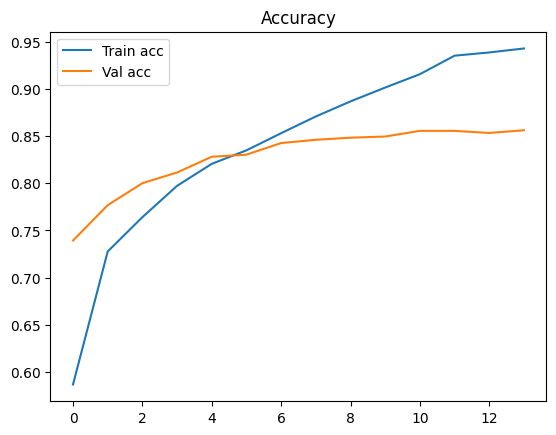

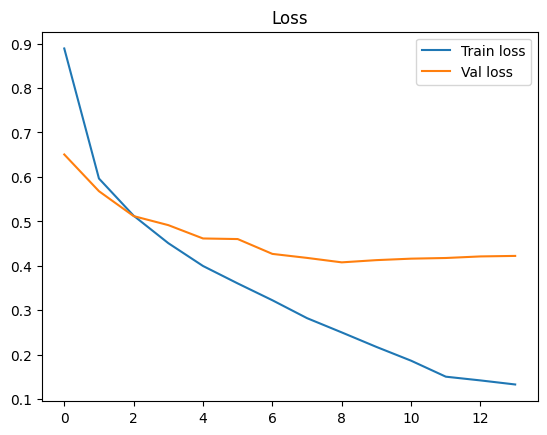

In [28]:

history_dict = history.history
# Accuracy
plt.plot(history_dict['accuracy'], label='Train acc')
plt.plot(history_dict['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss
plt.plot(history_dict['loss'], label='Train loss')
plt.plot(history_dict['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

#### Accuracy

- La précision d'entraînement commence à environ 0.60, puis augmente progressivement pour atteindre environ 0.95 après plusieurs époques.

- Cela montre que le modèle apprend bien à partir des données d'entraînement et devient plus précis à mesure qu'il progresse dans l'entraînement.



- La précision de validation suit une tendance similaire à celle de l'entraînement. Elle commence également à environ 0.60 mais augmente plus lentement que l'accuracy d'entraînement, atteignant environ 0.85 vers la fin de l'entraînement.



- L'écart entre l'accuracy d'entraînement et l'accuracy de validation est relativement faible, ce qui est bon signe. Cela indique que le modèle généralise bien, en réussissant à apprendre des motifs sur les données d'entraînement sans trop s'ajuster aux détails spécifiques de ces données.

#### Loss


- La perte commence à environ 0.8 et descend régulièrement pour atteindre 0.2 vers la fin de l'entraînement. Une diminution régulière de la perte montre que le modèle s'ajuste progressivement aux données d'entraînement.


- La perte de validation suit une trajectoire similaire à celle de l'entraînement, avec une diminution initiale. Cependant, après un certain point, la courbe de validation se stabilise autour de 0.4, ce qui indique que l'amélioration sur les données de validation est limitée à ce stade.

- Cela suggère que le modèle commence à se stabiliser sur l'ensemble de validation, même s'il continue à améliorer ses performances sur les données d'entraînement.


# **III- Evaluation du modèle et interprètation des résultats**

**Chargement du modèle**

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/project/H5PY/cnn_densenet121_modele03.keras')


**Chargement des données de test_ds**

In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/project/test",
    image_size=(128, 128),  # même taille que pour l'entraînement
    batch_size=32,
    shuffle=False
)


Found 4238 files belonging to 4 classes.


**Extraction des classes names**

In [30]:
class_names = test_ds.class_names

**Normalisation des données de test_ds**

In [31]:
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

**Evaluation de la performance**

In [32]:
# =====================================================================
# Évaluation du modèle sur les données de test
# =====================================================================

from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------------------------------------------------
# Fonction pour extraire :
# - les vraies étiquettes (true_labels)
# - les prédictions du modèle (pred_labels)
# - les probabilités associées à chaque classe (pred_probs)
# ---------------------------------------------------------------------
def get_predictions_labels_probs(dataset, model):
    true_labels = []
    pred_labels = []
    pred_probs = []

    # Parcourt le jeu de test par batch
    for images, labels in dataset:
        # Prédit les probabilités pour chaque classe
        preds = model.predict(images, verbose=0)

        # Stocke les probabilités (utile pour ROC, AUC, etc.)
        pred_probs.extend(preds)

        # Convertit les probabilités en labels (classe avec la plus forte proba)
        pred_labels.extend(np.argmax(preds, axis=-1))

        # Stocke les vraies étiquettes
        true_labels.extend(labels.numpy())

    # Retourne les trois tableaux sous forme numpy
    return np.array(true_labels), np.array(pred_labels), np.array(pred_probs)


# ---------------------------------------------------------------------
# Application de la fonction au jeu de test
# ---------------------------------------------------------------------
y_true, y_pred, y_prob = get_predictions_labels_probs(test_ds, model)

# ---------------------------------------------------------------------
# Rapport de classification
# ---------------------------------------------------------------------
# Affiche la précision, le rappel et le F1-score pour chaque classe,
# ainsi que les moyennes globales (macro / weighted).
# Permet d’évaluer le comportement du modèle par classe.
print(classification_report(y_true, y_pred))

# ---------------------------------------------------------------------
# Matrice de confusion
# ---------------------------------------------------------------------
# Montre le nombre de prédictions correctes et incorrectes pour chaque classe.
# Les diagonales représentent les bonnes prédictions.
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.76      0.73       724
           1       0.85      0.79      0.82      1204
           2       0.88      0.88      0.88      2040
           3       0.92      0.93      0.93       270

    accuracy                           0.84      4238
   macro avg       0.84      0.84      0.84      4238
weighted avg       0.84      0.84      0.84      4238

[[ 553   73   97    1]
 [ 111  957  134    2]
 [ 125   93 1804   18]
 [   3    1   14  252]]


### Rapport de classification

<ul>

**Classe 0 (COVID)** :

- La précision est de 0.70, ce qui signifie que 70% des prédictions comme COVID sont correctes.

- Le rappel est de 0.76, ce qui signifie que 76% des images réelles de COVID sont correctement identifiées.

- Le F1-Score de 0.73 montre un bon compromis entre précision et rappel. Cela indique que, bien que le modèle soit relativement bon pour identifier le COVID, il pourrait encore être amélioré.

**Classe 1 (Lung_Opacity)** :

- La précision est de 0.85, ce qui est assez bon, signifiant que 85% des prédictions pour cette classe sont correctes.

- Le rappel de 0.79 montre que 79% des images réelles de cette classe ont été détectées. Un rappel légèrement plus faible que la précision suggère qu'il y a quelques erreurs de faux négatifs.

- Le F1-Score de 0.82 indique un bon équilibre entre précision et rappel, ce qui est positif pour cette classe.

**Classe 2 (Normal)** :

- Avec une précision de 0.88 et un rappel de 0.88, le modèle performe très bien pour cette classe, identifiant correctement les images normales avec un équilibre élevé entre la précision et le rappel.

- Le F1-Score de 0.88 est également excellent, montrant que le modèle a une excellente capacité à prédire correctement les images normales.

**Classe 3 (Viral_Pneumonia)** :

- La précision est très élevée, à 0.92, ce qui montre que 92% des prédictions de pneumonie virale sont correctes.

-Le rappel est également excellent, à 0.93, signifiant que le modèle détecte 93% des images réelles de pneumonie virale.

- Le F1-Score de 0.93 est le plus élevé parmi toutes les classes, ce qui montre que le modèle est particulièrement performant pour cette classe.

**Performances globales**

- L'accuracy globale est de 0.84, ce qui signifie que le modèle a correctement classifié 84% des images dans l'ensemble des données. C'est un bon indicateur de performance générale.

</ul>

### Matrix de confusion

<ul>

- Classe COVID (0) : Le modèle fait des erreurs de prédiction de 73 images en tant que Lung_Opacity et 97 en tant que Normal. Cependant, il détecte correctement 553 images COVID.

- Classe Lung_Opacity (1) : Le modèle fait des erreurs de prédiction de 111 images en tant que COVID et 134 en tant que Normal, mais réussit à détecter 957 images correctement.

- Classe Normal (2) : Le modèle fait 125 erreurs de prédiction comme COVID et 93 erreurs comme Lung_Opacity, mais il détecte correctement 1804 images normales.

- Classe Viral_Pneumonia (3) : Le modèle fait seulement 3 erreurs de prédiction comme COVID et 14 erreurs comme Normal, mais il détecte 252 images correctement.

</ul>

**Visualisation: Inspection de quelques prédictions**


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


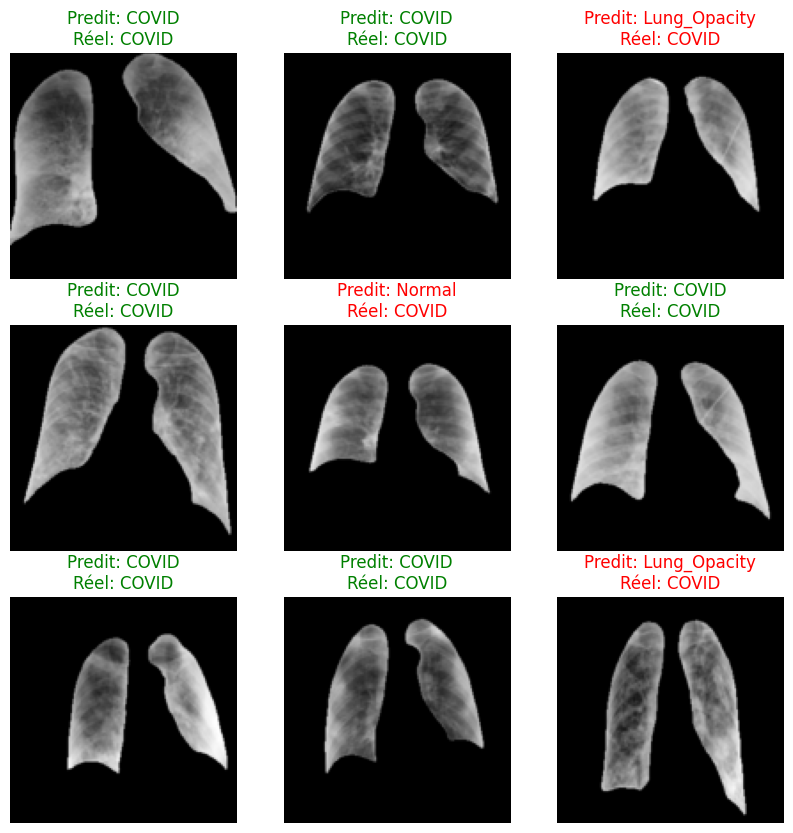

In [33]:
# Extraire quelques images et leurs prédictions
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Predit: {pred_label}\nRéel: {true_label}", color=color)
        plt.axis("off")


- **Courbe des valeurs réelles vs prédites**

**But général :**

 Comparer visuellement les prédictions du modèle (y_pred) avec les vraies étiquettes (y_test) sur un sous-échantillon pour identifier facilement les erreurs.

In [35]:
import numpy as np
import plotly.graph_objects as go

# Définition des classes
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

# Convertir y_true et y_pred en indices de classes
y_true_indices = y_true
y_pred_indices = y_pred

# Créer un sous-ensemble équilibré avec un nombre d'exemples fixe par classe
subset_size_per_class = 25  # Nombre d'exemples par classe dans le sous-ensemble
indices_balanced = []

# Sélectionner un nombre fixe d'exemples pour chaque classe
for i in range(len(class_names)):
    class_indices = np.where(y_true_indices == i)[0]
    if len(class_indices) >= subset_size_per_class:
        selected_indices = np.random.choice(class_indices, subset_size_per_class, replace=False)
    else:
        selected_indices = class_indices
    indices_balanced.extend(selected_indices)

indices_balanced = np.array(indices_balanced)
np.random.shuffle(indices_balanced)

# Vérification de la taille de indices_balanced pour éviter l'IndexError
print(f"Taille du sous-ensemble équilibré: {len(indices_balanced)}")

# Sous-ensemble de données équilibré
y_true_subset = y_true_indices[indices_balanced]
y_pred_subset = y_pred_indices[indices_balanced]

# Créer le graphique
fig = go.Figure()

# Points correctement classés
correct_mask = y_true_subset == y_pred_subset
incorrect_mask = y_true_subset != y_pred_subset

correct_indices = indices_balanced[correct_mask]
incorrect_indices = indices_balanced[incorrect_mask]

# Points correctement classés
fig.add_trace(go.Scatter(
    x=correct_indices,
    y=y_true_subset[correct_mask],
    mode='markers',
    name='Correctement classé',
    marker=dict(size=8, color='#00ff00', symbol='circle'),
    text=[f"Réel: {class_names[y]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i, y in enumerate(y_true_subset[correct_mask])],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Points mal classés
fig.add_trace(go.Scatter(
    x=incorrect_indices,
    y=y_true_subset[incorrect_mask],
    mode='markers',
    name='Mal classé',
    marker=dict(size=8, color='#e60000', symbol='x'),
    text=[f"Réel: {class_names[y_true_subset[i]]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i in np.where(incorrect_mask)[0]],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Modifier l'axe y pour afficher les classes de manière parallèle
fig.update_yaxes(
    tickvals=np.arange(len(class_names)),
    ticktext=class_names,
    title_text="Classe réelle",
    range=[-0.5, len(class_names) - 0.5]  # Ajuster pour que les classes soient centrées sur l'axe
)

fig.update_layout(
    title=f"Valeurs correctement et incorrectement classées sur {len(indices_balanced)} échantillons",
    xaxis_title="Index des échantillons",
    width=1000,
    height=600,
    showlegend=True
)

fig.show()


Taille du sous-ensemble équilibré: 100


- **confusion avec normalisation**

**But général :**

Vérifier quantitativement les performances du modèle sur le dataset de test.
La matrice de confusion montre combien d'échantillons de chaque classe ont été correctement ou incorrectement classés.

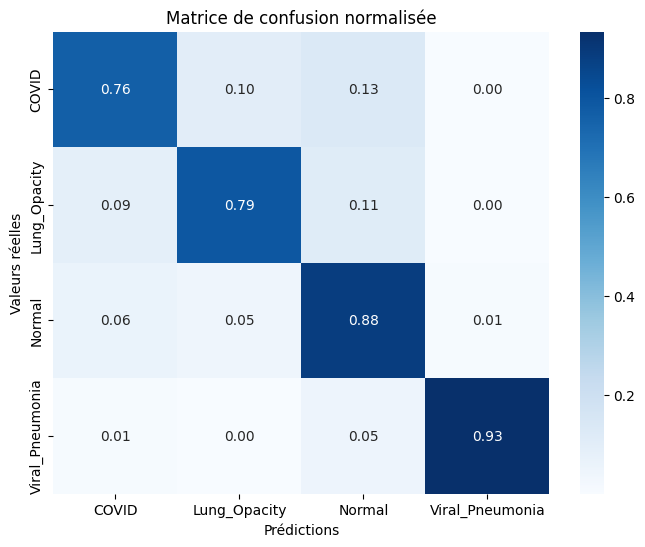

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Supposons que y_test et y_pred soient tes labels vrais et prédits sous forme d'entiers
# et class_names la liste de noms des classes dans l'ordre correspondant aux labels

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Normaliser la matrice de confusion pour obtenir les pourcentages par ligne
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.divide(cm, cm_sum, where=cm_sum!=0)  # éviter division par zéro

# Affichage avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Matrice de confusion normalisée")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()


- Les classes Normal et Viral_Pneumonia sont très bien reconnues.

- Le modèle a un peu plus de mal avec COVID et Lung_Opacity, qui sont souvent confondues entre elles.

- La performance globale est très bonne pour un modèle multi-classes à 4 catégories, surtout dans un domaine médical.

- **Courbes ROC et AUC pour la classe COVID-19**

**But général :**

Évaluer la capacité du modèle à distinguer les images positives (COVID) des négatives pour cette classe.

La courbe ROC (Receiver Operating Characteristic) montre le compromis entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR).


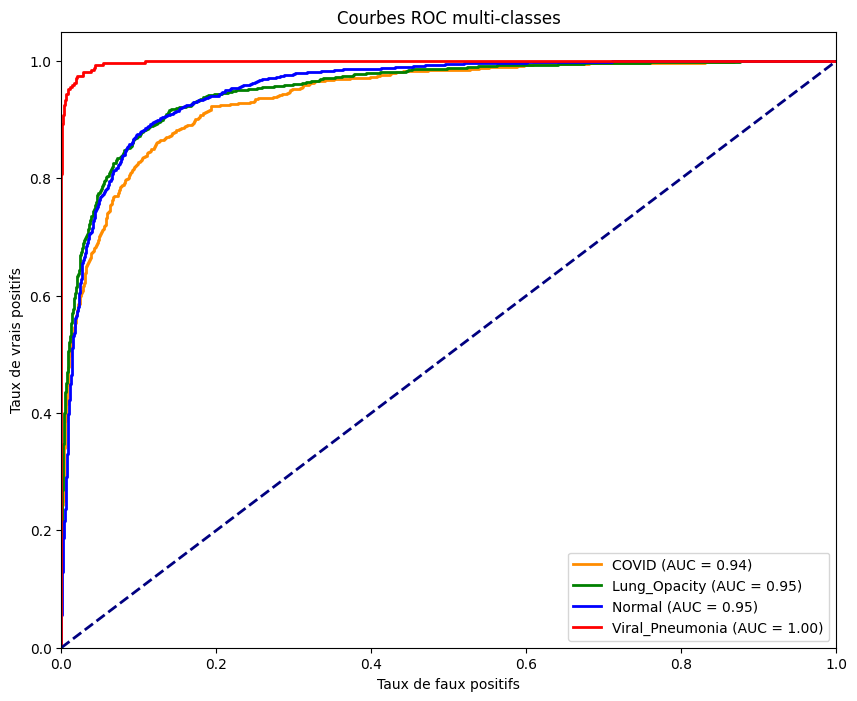

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binariser les vraies étiquettes
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
colors = ['darkorange', 'green', 'blue', 'red']

plt.figure(figsize=(10, 8))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC multi-classes')
plt.legend(loc="lower right")
plt.show()


# Lecture:

<ul>

1. Classe 2 est la mieux reconnue → c’est celle que le modèle distingue le mieux.

2. Classe 3 (probablement la minoritaire) n’est jamais reconnue → le modèle ne la prédit presque jamais.

3. Précision globale : ~40 %, donc le modèle n’a pas encore appris à bien séparer les classes.
</ul>

# Analyse

<ul>

Analyse des causes probables

1. Déséquilibre de classes
→ Ton class_weight est déjà là, mais peut-être pas assez fort.
Vérifie combien d’images tu as par classe (df_all['label'].value_counts()).

2. Classe 3 ignorée

<ul>
→ Le modèle n’a probablement pas assez d’exemples de cette classe, ou ils sont trop différents.

→ Vérifie si les images de cette classe sont bien distribuées et correctes.
</ul>
3.  Apprentissage insuffisant

<Ul>
-> 10 époques peuvent être trop peu pour DenseNet121 (souvent il faut 20–30 pour stabiliser).

-> Tu peux débloquer quelques couches du backbone (fine-tuning) pour améliorer la spécialisation.
</ul>
4. Taille d’image / prétraitement
</ul>


### Visualisation et Interprétation des Prédictions avec Grad-CAM sur un Modèle DenseNet169 Pré-entraîné

Model loaded. input shape = (None, 128, 128, 3)
Found 4238 files belonging to 4 classes.
4 images sélectionnées pour Grad-CAM.
Dernière couche Conv2D utilisée pour Grad-CAM : **conv5_block32_2_conv**


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))



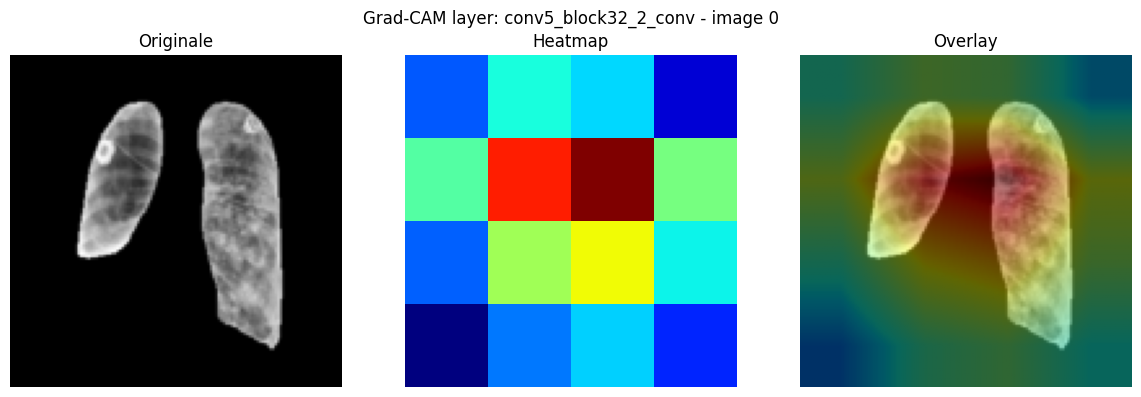

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Image 0 -> classe prédite: 1 (p=1.000)


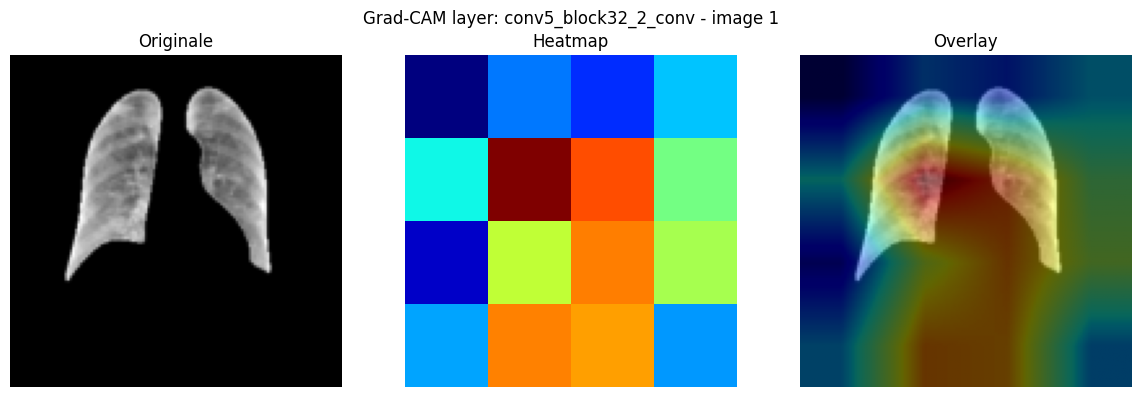

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Image 1 -> classe prédite: 0 (p=0.891)


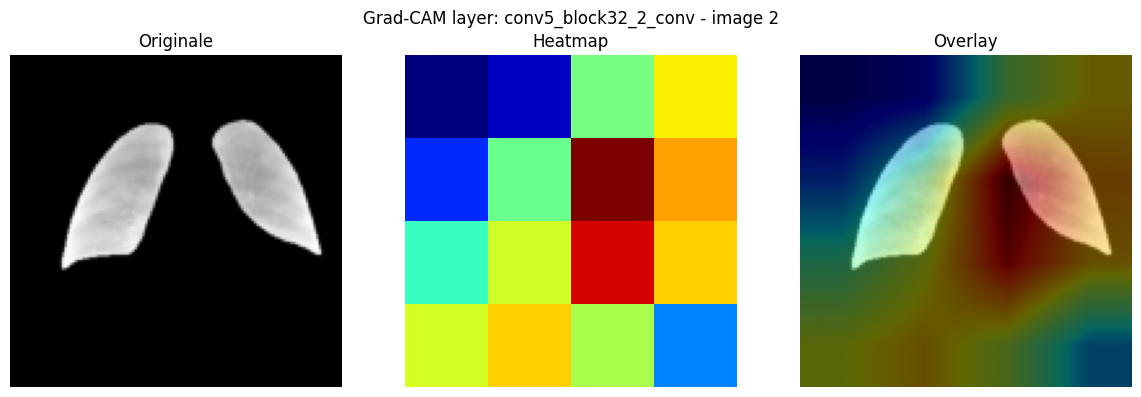

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Image 2 -> classe prédite: 1 (p=0.679)


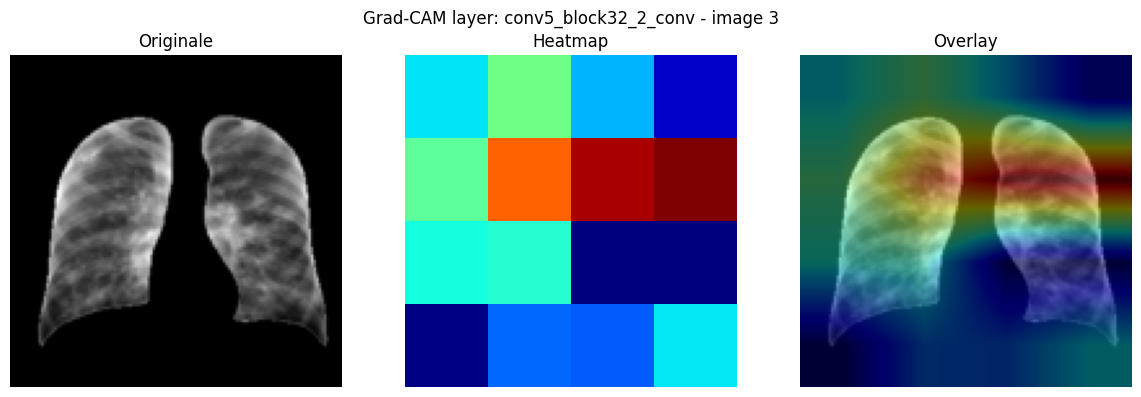

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Image 3 -> classe prédite: 2 (p=0.798)


In [39]:
# -------------------------
# UTILITAIRES
# -------------------------
def preprocess_image(img, target_size=None):
    """Prétraitement basique : convertir en float32 et normaliser entre 0-1."""
    img = img.astype(np.float32)
    if img.ndim == 2:
        img = np.expand_dims(img, -1)  # H,W,1
    if img.shape[-1] == 1:
        img = np.concatenate([img, img, img], axis=-1)
    if target_size is not None:
        img = tf.image.resize(img, target_size).numpy()
    img = img - img.min()  # Normalisation 0-1
    if img.max() != 0:
        img = img / img.max()
    return img

def save_image(img_array, path):
    """Sauvegarde un numpy array HxWx3 (0..1) en PNG"""
    arr = np.clip(img_array * 255.0, 0, 255).astype(np.uint8)
    pil = array_to_img(arr)
    pil.save(path)

# -------------------------
# GRAD-CAM
# -------------------------
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index=None):
    """Calcule la heatmap Grad-CAM pour une image donnée."""
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Choisir la classe avec la probabilité la plus élevée
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        return np.zeros_like(heatmap.numpy())
    heatmap = heatmap / max_val
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=plt.cm.jet):
    """Superpose la heatmap sur l'image originale."""
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()
    heatmap_resized = heatmap_resized.squeeze()
    cmap = colormap(heatmap_resized)[:, :, :3]
    overlay = (1 - alpha) * img + alpha * cmap
    overlay = np.clip(overlay, 0, 1)
    return overlay, cmap

# -------------------------
# ROUTINE PRINCIPALE
# -------------------------
def show_and_save_gradcam_for_images(images, model, layer_name, out_dir='gradcam_outputs', target_size=None, alpha=0.4):
    """Applique Grad-CAM pour un ensemble d'images et sauvegarde les résultats."""
    os.makedirs(out_dir, exist_ok=True)
    input_shape = model.input_shape
    model_target = None
    if input_shape is not None and len(input_shape) == 4 and input_shape[1] is not None:
        model_target = (input_shape[1], input_shape[2])

    for idx in range(images.shape[0]):
        raw = images[idx]
        pre = preprocess_image(raw, target_size=model_target)
        img_tensor = np.expand_dims(pre, axis=0).astype(np.float32)

        heatmap = make_gradcam_heatmap(img_tensor, model, layer_name, pred_index=None)
        overlay, cmap_img = overlay_heatmap_on_image(pre, heatmap, alpha=alpha)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title('Originale')
        plt.imshow(pre)
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title('Heatmap')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title('Overlay')
        plt.imshow(overlay)
        plt.axis('off')

        plt.suptitle(f'Grad-CAM layer: {layer_name} - image {idx}')
        plt.tight_layout()
        plt.show()

        save_image(pre, os.path.join(out_dir, f'image_{idx:03d}_orig.png'))
        save_image(overlay, os.path.join(out_dir, f'image_{idx:03d}_gradcam_overlay.png'))
        save_image(cmap_img, os.path.join(out_dir, f'image_{idx:03d}_heatmap_color.png'))

        preds = model.predict(img_tensor)
        pred_class = np.argmax(preds[0])
        pred_prob = preds[0][pred_class]
        print(f'Image {idx} -> classe prédite: {pred_class} (p={pred_prob:.3f})')

# -------------------------
#  Application sur le modèle DenseNet169
# -------------------------
if __name__ == '__main__':
    model_path = '/content/drive/MyDrive/project/H5PY/cnn_densenet169_modele.keras'
    test_dir = '/content/drive/MyDrive/project/test'
    out_dir = '/content/drive/MyDrive/project/gradcam169'

    # Charger le modèle
    model = tf.keras.models.load_model(model_path)
    print('Model loaded. input shape =', model.input_shape)

    # Charger les données de test depuis le répertoire
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=(128, 128),
        batch_size=1,
        label_mode='int'
    )

    # Convertir les images et labels en numpy arrays
    X_test = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)
    y_test = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

    # Sélectionner une image de chaque classe (par exemple, une image de chaque sous-dossier)
    selected_images = []
    class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral_Pneumonia']

    for class_name in class_names:
        class_idx = class_names.index(class_name)
        class_images = X_test[y_test == class_idx]
        if class_images.shape[0] > 0:
            selected_images.append(class_images[0])

    selected_images = np.array(selected_images)
    print(f'{selected_images.shape[0]} images sélectionnées pour Grad-CAM.')

    # Trouver la dernière couche Conv2D automatiquement
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    layer_name = conv_layers[-1]
    print(f"Dernière couche Conv2D utilisée pour Grad-CAM : **{layer_name}**")

    # Appliquer Grad-CAM et sauvegarder les résultats
    show_and_save_gradcam_for_images(selected_images, model, layer_name, out_dir=out_dir, target_size=(128, 128), alpha=0.4)


## Interprétation



### Heatmap de Grad-CAM (Gradient-weighted Class Activation Map) :

 Cette carte de chaleur montre quelles zones de la radiographie ont été les plus importantes pour la prédiction du modèle. Pour une image radiographique :



- Le modèle semble se concentrer sur des zones spécifiques des poumons qui pourraient être affectées par l'infection. Cela est typique dans les radiographies de COVID-19 où des infiltrations, des opacités ou des anomalies pulmonaires sont présentes, souvent sous forme de zones floues ou de zones d'ombrages dans les poumons. Le modèle a probablement identifié ces régions comme étant pertinentes pour la classification du COVID.

- Pour une image classée comme Pneumonia, on peut observer une activation similaire dans les régions des poumons qui montrent des signes de pneumonie, comme des infiltrations pulmonaires. Le modèle pourrait être sensible aux anomalies de densité dans les poumons.

- Pour une image  classée comme Lung Opacity, les zones d'opacité dans les poumons sont mises en évidence par des couleurs vives (rouge et jaune) sur la heatmap, ce qui suggère que le modèle se concentre sur la détection de ces opacités.

- Pour une image classée comme Normal, le modèle n'a pas  activé la carte de chaleur, car il n'y a pas d'anomalie à détecter dans une radiographie normale.



### Overlay (Superposition) :

L'overlay combine l'image d'origine et la carte de chaleur. Cette superposition permet de voir comment le modèle interprète l'image. Par exemple :

- Si la carte de chaleur est bien superposée sur des régions d'opacités, de taches ou de zones d'infiltration dans les poumons, cela montre que le modèle se concentre sur ces signes cliniques qui sont associés aux pathologies spécifiques (COVID, Pneumonia, Lung Opacity).

- Si l'overlay montre une concentration sur des zones anormales (par exemple, dans les radiographies de COVID ou Pneumonia), cela indique que le modèle a correctement appris à identifier ces caractéristiques distinctives.

- Si l'activation est faible ou absente sur une image "Normale", cela est également un bon signe, car cela montre que le modèle ne détecte pas d'anomalies là où il ne devrait pas.

